# Vantage-AI case project

For this project we'll be using both R and python.
R is used for more exploratory analyses and less automated analysis work. Once we understand the data and have
a clear idea of which rules to implement for data cleaning, then we can continue working with Python to set up pipelines with the `scikit-learn` library. 

The goal of this case is to predict the need of repair of water pumps, effectively a fairly standard classification problem.
What makes it hard is that there are many features that consists of an intractable amount of labels, meaning we can't just use them as categories since many categories will only have 1 or 2 observations; there won't be enough observations per 'category' to train a model

## Reticulate package

The `reticulate` package is used to run python code. This way we can do some basic computation steps by writing python code within our R script, making it easier to port the resulting code to dedicated Python scripts to automate the analysis from raw data to the final result.

After a LOT of trial and error the reticulate package now works pretty cleanly with `conda`. You can use `conda` as a package manager for both R and Python, as opposed to R package manager `packrat` or the widely used `virtualenv` for python.

## Project directory structure

The directory structure was taken from the BigData Republic GitHub! By doing this I hope to learn more about the preferred project structure at BDR.

The cookiecutter-data-science repository can be found here https://github.com/BigDataRepublic/cookiecutter-data-science. Now, what makes this truly come full circle is that... 

   - The Tanzania Water Pump data was originally hosted by **DrivenData** for a data science competition
       * Hosted here https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
       * Original data made available by [Taarifa](http://taarifa.org) and [Tanzania Ministry of Water](http://maji.go.tz/)
   - The Github repository from BDR is actually a fork from https://github.com/drivendata/cookiecutter-data-science !
       * Changes include getting rid of `virtualenv` , thus only using `conda`
       * Source code directory named after the project instead of just `src`
       
While the directory structure is completely overkill for a project like this, it still serves its purpose as a standardized data science project directory. Even if project are small, finding the code isn't usually straightforward... Unless you already know the file structure, then it becomes a piece of cake!
        

# Exploratory analysis

Before we move to modelling and actual data cleaning, let's explore the data to get a feeling for the data.

In [270]:
# Load libraries
library(tidyverse)
library(broom)
library(ggthemes)
library(DT)

In [271]:
# Library to use python code using our conda environment
library(reticulate)
py_config()

python:         D:\Anaconda\envs\vantage-project\python.exe
libpython:      D:/Anaconda/envs/vantage-project/python36.dll
pythonhome:     D:\Anaconda\envs\vantage-project
version:        3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
Architecture:   64bit
numpy:          D:\Anaconda\envs\vantage-project\lib\site-packages\numpy
numpy_version:  1.15.2

python versions found: 
 D:\Anaconda\envs\vantage-project\python.exe
 D:\Anaconda\python.exe

# Predicting Tanzania water pump maintenance

### The data

The case presented here is about water pumps in Tanzania. The data set originates from the Tanzanian Ministry of Water. Currently, this ministry maintains its pumps based on a maintenance schedule or, of course, when they break down. We feel that the maintenance of the Tanzanian water pumps could improve in both the cost of maintenance and the prevention of break downs by introducing machine learning to predict if a water pump is in need of repair or even the moment of failure of each water pump. 

### Objective

Our objective is to develop a reproducible model that can predict which pumps will fail in the future, either the moment or just whether they fail. The resulting model is to be used by the Tanzanian government to effectively maintain their water pumps.

Normally for this type of data you would expect that a single water pump was measured
over-time and using this data we could predict the need for repairs for a given pump. In this case however, at 
every practically every timepoint a different water point was measured! So we have to make some assumptions about the
data and the approach to how we create a model.

#### Assumptions

**We should know in advance which water point should be predicted**, there must be something like a 
maintenance schedule at least 3 days ahead. We make this assumption because we have to able to take
into account the measured variables about the water pumps.!

**Measured variable should all be assumed to be known in advance**, otherwise we should choose
to leave out some variables that may have only become known at the time of determining the functioning of a water pump.
Variables like the `funder` and `district_code` are clearly known ahead of maintenance, but other variables like 
`water_quality` and `amount_tsh` (total amount water available to waterpoint) may not be known before determining the state of the pump.

# Getting a feeling for the data

Before we start modelling the data we should understand the data. In this dataset
we find a total of 40 measured variables to be used as features in our models. In this
section we will aim to understand these features and make motivated choices to keep, remove or transform these
features from our prediction model.

## A closer look at our features

Our data consists of,
  - `r nrow(df)` observations 
  - `r ncol(df)` features
  - `r length(unique(labels[,2]))` types of labels to predict
  
Not all of the features are necessarily useful for predicting the moment of failure of water pumps, 
for instance the measurement `id` won't be of much use at it is unique.

First we'll take a look at the raw data to fully understand the structure of our data,
especially how exactly the data was measured over time. We have `r nrow(df)` observations.

### The raw data

The raw data is not considered big-data in the sense that it will fit on a single machine; we do not have to worry about batch processing because of sheer file size with 'only' `r nrow(df)` observations. The number of features is also a mere `r ncol(df)`! Enough to make a interpretable predictive model and this will allow us to dive deeper into the
individual variables.

In [303]:
# Read local data
#   Expect to be synced with data hosten on Amazon S3 
data <- read.csv("../../data/raw/water_pump_set.csv")
labels <- read.csv("../../data/raw/water_pump_labels.csv")
features <- read.csv("../../data/raw/water_pump_features.csv")
# Merge labels and features into single dataset by id
df <- merge(data, labels, by="id")
head(df)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0,2012-11-13,Tasaf,0,TASAF,33.12583,-5.118154,Mratibu,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,0,2011-03-05,Shipo,1978,SHIPO,34.77072,-9.395642,none,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,0,2011-03-27,Lvia,0,LVIA,36.11506,-6.279268,Bombani,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,10,2013-06-03,Germany Republi,1639,CES,37.14743,-3.187555,Area 7 Namba 5,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,0,2011-03-22,Cmsr,0,CMSR,36.16489,-6.099289,Ezeleda,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
5,50,2011-02-26,Private,28,Private,39.28612,-6.972403,Kwa Namaj,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [273]:
# 39 features,to use for modelling a unique id and the status_group labels
# Total of 59400 observations
dim(df)

[1] 59400    41

In [274]:
# Show the feature descriptions
#   This excludes the 'status'group'
head(features)

Feature,Description
amount_tsh,Total static head (amount water available to waterpoint)
date_recorded,The date the row was entered
funder,Who funded the well
gps_height,Altitude of the well
installer,Organization that installed the well
longitude,GPS coordinate


In [304]:
# Let's add some more info to the feature info using tidyverse piping
feature_desc <- features %>% filter(Feature %in% colnames(data)) %>%
  mutate(example = sapply(data[1, -1], as.character), # First row of the data without the 'id' column
         unique = map_int(data[,-1],function(x) length(unique(x))),
         type = map_chr(data[,-1], function(x) class(unlist(x))), # 
         nonzero = map_int(data[,-1], function(x) sum(as.character(x) != "0")), # Nonzero values, assuming 0 usually means NA
         max_single = map_int(data[,-1], function(x) max(table(x))),      # Observations of most occuring value
         max_occurence = map_chr(data[,-1], function(x) names(which.max(table(x))))) # Highest occuring value
                                 
# Let's glance at the numeric values in the dataset                               
feature_desc %>% filter(type %in% c("numeric", "integer"))                
feature_desc %>% filter(type %in% c("numeric", "integer")) %>% dim()

Feature,Description,example,unique,type,nonzero,max_single,max_occurence
amount_tsh,Total static head (amount water available to waterpoint),6000,98,numeric,17761,41639,0
gps_height,Altitude of the well,1390,2428,integer,38962,20438,0
longitude,GPS coordinate,34.93809275,57516,numeric,57588,1812,0
latitude,GPS coordinate,-9.85632177,57517,numeric,59400,1812,-2e-08
num_private,,0,65,integer,757,58643,0
region_code,Geographic location (coded),11,27,integer,59400,5300,11
district_code,Geographic location (coded),5,20,integer,59377,12203,1
population,Population around the well,109,1049,integer,38019,21381,0
construction_year,Year the waterpoint was constructed,1999,55,integer,38691,20709,0


[1] 9 8

The number of unique values for each numerical feature is surprising in some cases. Continuous values like,
 - `gps_height`
 - `population`
 - `amount_tsh`
 
 all have a very low number of unique values. So, even though we have not seen any `NA` values in the data, but there must be some missing values. These values are simply set to `0`, it is unclear to me whether we can distinguish true `0` values from missing values.
 
 ### Non-numeric summaries

In [305]:
# Show non-numeric value summary
feature_desc %>% filter(!type %in% c("numeric", "integer"))
feature_desc %>% filter(!type %in% c("numeric", "integer")) %>% dim()

Feature,Description,example,unique,type,nonzero,max_single,max_occurence
date_recorded,The date the row was entered,2011-03-14,356,factor,59400,572,2011-03-15
funder,Who funded the well,Roman,1898,factor,58623,9084,Government Of Tanzania
installer,Organization that installed the well,Roman,2146,factor,58623,17402,DWE
wpt_name,Name of the waterpoint if there is one,none,37400,factor,59400,3563,none
basin,Geographic water basin,Lake Nyasa,9,factor,59400,10248,Lake Victoria
subvillage,Geographic location,Mnyusi B,19288,factor,59400,508,Madukani
region,Geographic location,Iringa,21,factor,59400,5294,Iringa
lga,Geographic location,Ludewa,125,factor,59400,2503,Njombe
ward,Geographic location,Mundindi,2092,factor,59400,307,Igosi
public_meeting,True/False,True,3,factor,59400,51011,True


[1] 30  8

### Handling feature groups

The variables in the data are far from independent, some variables practically mean the same thing.
Some feature groups are so painfully obvious that we should clean these manually before moving on to
more generic analyses.

In the `Description` column, we can see some overlap in values. These features are likely to represent the same
variable, so we can reduce the dimensionality of the dataset just by smartly combining some variables.

Let's start with common sense and group some of the variables manually to prepare the data
for more automated pipelines. Here are some logical groups we can check,

  - scheme_name, scheme_management, installer, funder
  - extraction_type, extraction_type_group, extraction_type_class
  - management, management_group
  - scheme_management, scheme_name
  - payment, payment_type
  - water_quality, quality_group
  - quantity_quantity_group
  - source, source_class
  - waterpoint_type, waterpoint_type_group
  
 #### Scheme_name, scheme_management, installer, funder
 


In [277]:
data %>% 
    select(scheme_name, scheme_management, installer, funder) %>%
    mutate_all(as.character) %>%
    mutate_all(tolower) %>% # To lowercase since there are many typing 'errors' or inconsistencies
    group_by(scheme_name, scheme_management, installer, funder) %>%
    tally() %>% 
    arrange(desc(n)) %>% 
    head(10)

scheme_name,scheme_management,installer,funder,n
,vwc,,,1311
,vwc,kkkt,kkkt,841
,vwc,dwe,hesawa,616
,vwc,government,government of tanzania,615
,vwc,dwe,government of tanzania,600
,wug,dwe,dwsp,567
,,dwe,rwssp,522
k,vwc,,,513
,wug,dwe,netherlands,457
,vwc,hesawa,hifab,450


In [278]:
# Scheme names
data %>% select(scheme_name) %>% table() %>% sort(decreasing = T) %>% head()
# Half the data is missing data, and the rest is extremely scattered
# Furthermore there are many unambiguous names and spelling errors like 'Adra', 'ADRA', 'WOULD BANK', etc..
df %>%
    filter(scheme_name != "") %>%
    group_by(scheme_name, status_group) %>%
    tally() %>% head(20)
# Based on this we remove the scheme_name entirely

.
                          K          None      Borehole Chalinze wate 
        28166           682           644           546           405 
            M 
          400 

scheme_name,status_group,n
14 Kambarage,functional,7
A,functional,23
A,functional needs repair,2
A,non functional,17
ADP,functional,6
ADP,non functional,3
ADP Simbo,functional,15
ADP Simbo,non functional,10
ADP Simbu,non functional,1
Adra,functional,1


.
            VWC             WUG                 Water authority             WUA 
          36793            5206            3877            3153            2883 
    Water Board 
           2748 

Scheme mangement in 10 groups accounts for 100.00% of the data. And just VWC is 61.94%

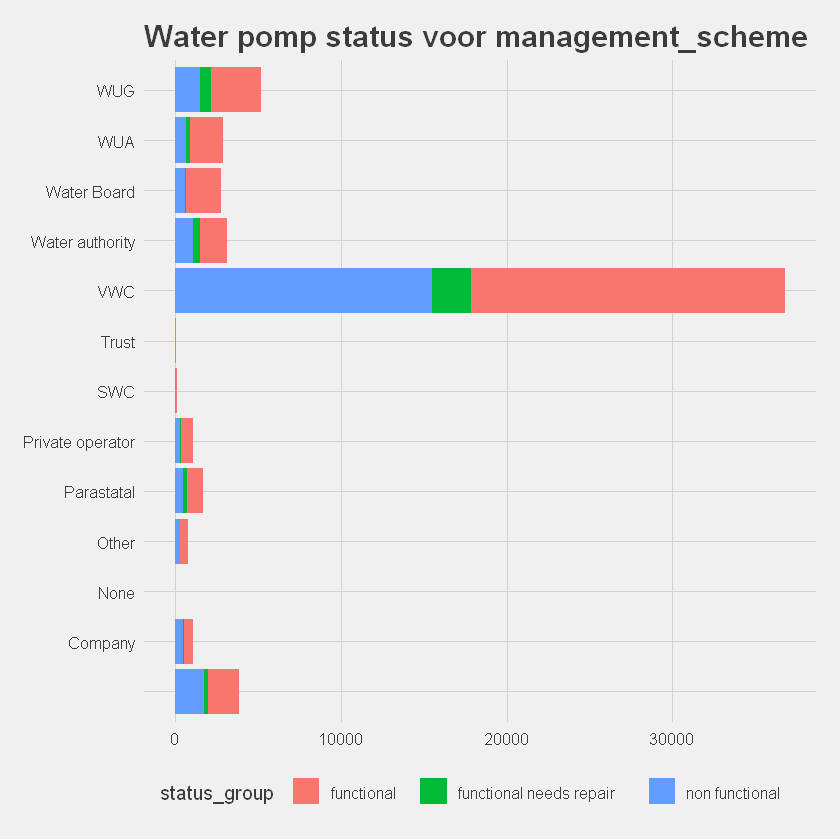

In [279]:
# Scheme management
data %>% select(scheme_management) %>% table() %>% sort(decreasing = T) %>% head()
# Plot label per scheme_management
df %>% select(scheme_management, status_group) %>%
    ggplot(aes(x = scheme_management, fill = status_group)) +
    geom_bar() + coord_flip() +
    ggtitle("Water pomp status voor management_scheme") +
    theme_fivethirtyeight()

# Most of the water pumps are from a handful of installers. 
# We could consider grouping all the low occurences into a group 'other'
# Plot label per scheme_management
scheme_management_groups = df %>% select(scheme_management, status_group) %>%
    group_by(scheme_management) %>%
    tally() 

cat(sprintf("Scheme mangement in 10 groups accounts for %1.2f%% of the data. And just VWC is %1.2f%%", 
            100 * sum(scheme_management_groups$n) / nrow(df),
            100 * max(scheme_management_groups$n) / nrow(df)))


.
       DWE            Government        RWE      Commu     DANIDA 
     17402       3655       1825       1206       1060       1050 

[1] 2146

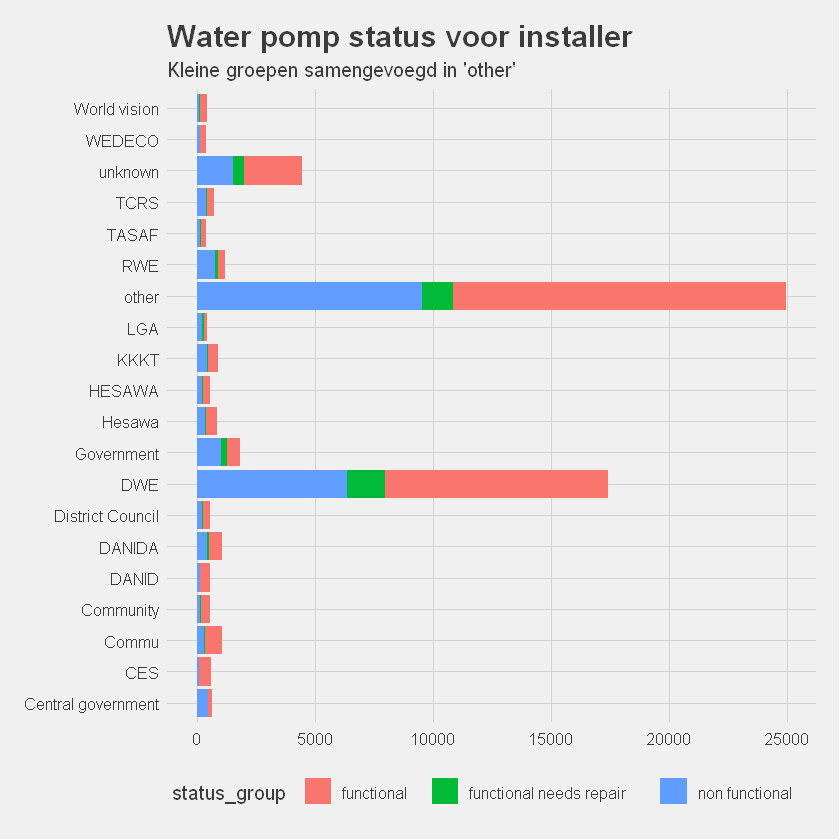

In [280]:
# installer
data %>% select(installer) %>% table() %>% sort(decreasing = T) %>% head()
length(unique(data$installer))

# Most of the water pumps are from a handful of installers. 
# We could consider grouping all the low occurences into a group 'other'
# Plot label per scheme_management
installer_groups = df %>% select(installer, status_group) %>%
    group_by(installer) %>%
    tally() %>%
    top_n(20, n)

# Plot installer versus status_group to verify 
df %>% select(installer, status_group) %>%
    mutate(installer = ifelse(installer %in% installer_groups$installer, as.character(installer), "other"),
           installer = ifelse(installer %in% c("", "0"), "unknown", installer)) %>%
    ggplot(aes(x = installer, fill = status_group)) +
    geom_bar() + coord_flip() +
    ggtitle("Water pomp status voor installer", subtitle = "Kleine groepen samengevoegd in 'other'") +
    theme_fivethirtyeight() 

# Show counts of installer labes, only top20
# Notice that many of these have about the same number of observations and grouping all the others into
# 'other' is quite arbitrary since the 'other' group will still be half the data. 
# The number of 'larger' groups and the number of spelling errors in the data require more detailed feature engineering
# like some kind of string matching- which we will not spend our time on.
# THIS FEATURE WILL BE REMOVED FROM THE MODELLING DATA

In [281]:
# funder
data %>% select(funder) %>% table() %>% sort(decreasing = T) %>% head()

cat(sprintf("Of the %i unique funder names, %i overlap with the installer names!",
            length(unique(data$funder)),
            length(intersect(tolower(as.character(data$funder)), tolower(as.character(data$installer))))))
# Due to the high overlap between funder and installer, we can assume that these two are heavily related and 
# will probably give us the same difficulty as the funder names by themselves.
# WE REMOVE THIS FEATURE FROM THE DATASET!

.
Government Of Tanzania                                        Danida 
                  9084                   3635                   3114 
                Hesawa                  Rwssp             World Bank 
                  2202                   1374                   1349 

Of the 1898 unique funder names, 1065 overlap with the installer names!

In [282]:
# Groups for each extraction type to determine which has the most information
df %>% select(extraction_type, extraction_type_group, extraction_type_class) %>%
  apply(2, function(x) length(unique(x)))

# Count label co-occurences to potentially remove some features as we have a 
# tractable number of features (not 100s this time!)
df %>%
    group_by(extraction_type, extraction_type_group, extraction_type_class) %>%
    tally()

extraction_type extraction_type_group extraction_type_class 
                   18                    13                     7

extraction_type,extraction_type_group,extraction_type_class,n
afridev,afridev,handpump,1770
cemo,other motorpump,motorpump,90
climax,other motorpump,motorpump,32
gravity,gravity,gravity,26780
india mark ii,india mark ii,handpump,2400
india mark iii,india mark iii,handpump,98
ksb,submersible,submersible,1415
mono,mono,motorpump,2865
nira/tanira,nira/tanira,handpump,8154
other,other,other,6430


By far the most prevalent type of waterpump is the gravity water pump type. This type of pump is eco-friendly as it does not use energy other than gravity.

Notice that there are some very small groups in the data,  mostly due to the inclusion of `extraction_type`. The `extraction_type` has some values that we could combine with other categories to reduce the dimensionality.

  - **india mark ii** and **india mark iii** can be combined to just **india mark**
  - **cemo** and **climax** are just two types of motorpumps, let's not differentiate these two
  - **other - mkulima/shinyanga** is very specific, we can just classify this as handpump together with **play pump** and **walimi**
  - Lastly the **swn 81** and **swn 80** are both handpumps, we can classifiy these as **swn**
      * The SWN 80 and SWN 81 type of handle pumps only differ in their pump head so that the SWN 81 can reach deeper wells. [Read more about handpumps here:)](https://www.ircwash.org/sites/default/files/232.2-13249.pdf)
      * Fun fact, the SWN stands for 'Sociale Werkplaats Nunspeet'! The SWN family of pumps was introduced partly by a workshop for the handicapped in the Netherlands sine 1976.

Let's manually combine some of the feature groups into related groups.

extraction_type,extraction_type_class,n
afridev,handpump,1770
gravity,gravity,26780
handpump,handpump,135
india mark,handpump,2498
ksb,submersible,1415
mono,motorpump,2865
motorpump,motorpump,122
nira/tanira,handpump,8154
other,other,6430
other - rope pump,rope pump,451


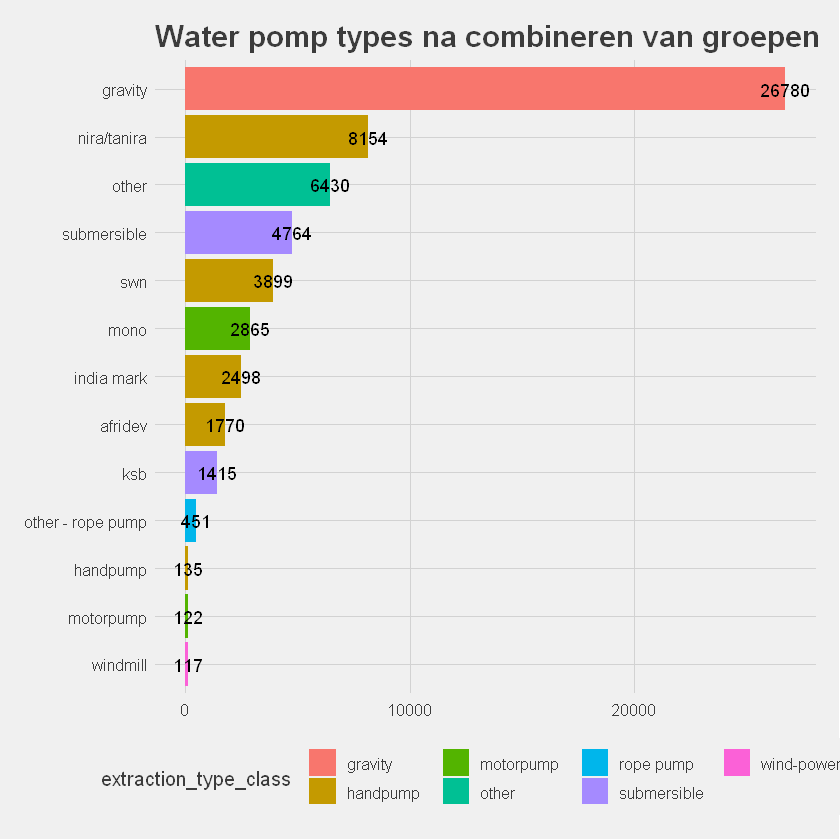

In [403]:
# Temporary data about the extraction type
df_extraction <- df %>% 
    mutate(
        extraction_type = as.character(extraction_type),
        extraction_type = ifelse(extraction_type %in% c("india mark ii", "india mark iii"), "india mark", extraction_type),
        extraction_type = ifelse(extraction_type %in% c("cemo", "climax"), "motorpump", extraction_type),
        extraction_type = ifelse(extraction_type %in% c("other - swn 81", "swn 80"), "swn", extraction_type),
        extraction_type = ifelse(extraction_type %in% c('other - mkulima/shinyanga','other - play pump', 'walimi'), "handpump", extraction_type)
           ) %>%
    select(id, extraction_type, extraction_type_class)

df_extraction %>% group_by(extraction_type, extraction_type_class) %>% tally()

# Make a new table of group counts
df_extraction %>% 
    mutate(extraction_group = paste(extraction_type, extraction_type_class, sep="-")) %>%
    group_by(extraction_group, extraction_type, extraction_type_class) %>%
    tally() %>%
    arrange(n) %>%
    ungroup() %>%
    mutate(extraction_type = factor(extraction_type, levels=extraction_type)) %>% # Relevel to reorder plot
    ggplot(aes(x = extraction_type, y = n, label = n, fill = extraction_type_class)) +
        geom_bar(stat="identity", position="dodge") + 
        ggtitle("Water pomp types na combineren van groepen") +
        geom_text() + coord_flip() + theme_fivethirtyeight()

Using two out of three extraction types, after some adjustments, in the data we can classify all the data in a way that none of the groups is truly underrepresented.

#### management, management_group

These two variables seem to mean the exact same thing.

In [284]:
# Cross table of only two variables
table(df %>% select(management, management_group))
# The management variable has more information than management_group


                  management_group
management         commercial other parastatal unknown user-group
  company                 685     0          0       0          0
  other                     0   844          0       0          0
  other - school            0    99          0       0          0
  parastatal                0     0       1768       0          0
  private operator       1971     0          0       0          0
  trust                    78     0          0       0          0
  unknown                   0     0          0     561          0
  vwc                       0     0          0       0      40507
  water authority         904     0          0       0          0
  water board               0     0          0       0       2933
  wua                       0     0          0       0       2535
  wug                       0     0          0       0       6515

We will select the column with *more* information, so we keep the `management` variable and drop the `management_group`.

#### Payment and payment_type

The payment and payment type columns also mean the exact same thing.

In [285]:
# Cross table of only two variables
df %>% group_by(payment, payment_type) %>% tally()
# The payments are exactly the same, we can drop either one.


payment,payment_type,n
never pay,never pay,25348
other,other,1054
pay annually,annually,3642
pay monthly,monthly,8300
pay per bucket,per bucket,8985
pay when scheme fails,on failure,3914
unknown,unknown,8157


The payment_type variables are more concise so we will drop the `payment` column

In [286]:
# Cross table of only two variables
df %>% group_by(water_quality, quality_group) %>% tally()



water_quality,quality_group,n
coloured,colored,490
fluoride,fluoride,200
fluoride abandoned,fluoride,17
milky,milky,804
salty,salty,4856
salty abandoned,salty,339
soft,good,50818
unknown,unknown,1876


The water quality intuitively seems like it would be predictive of the water pump status.

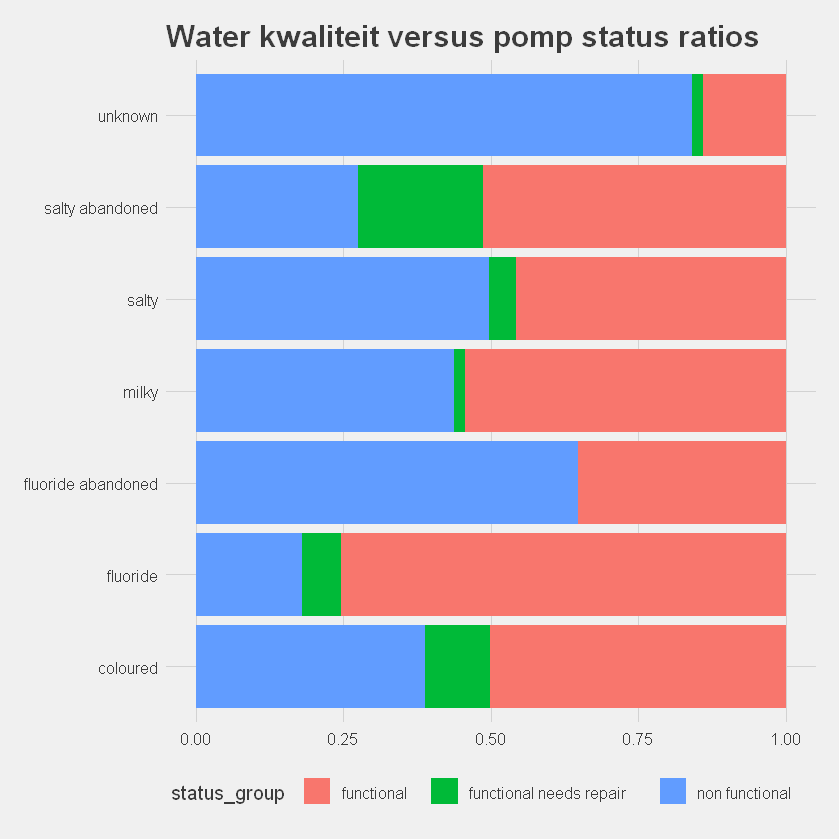

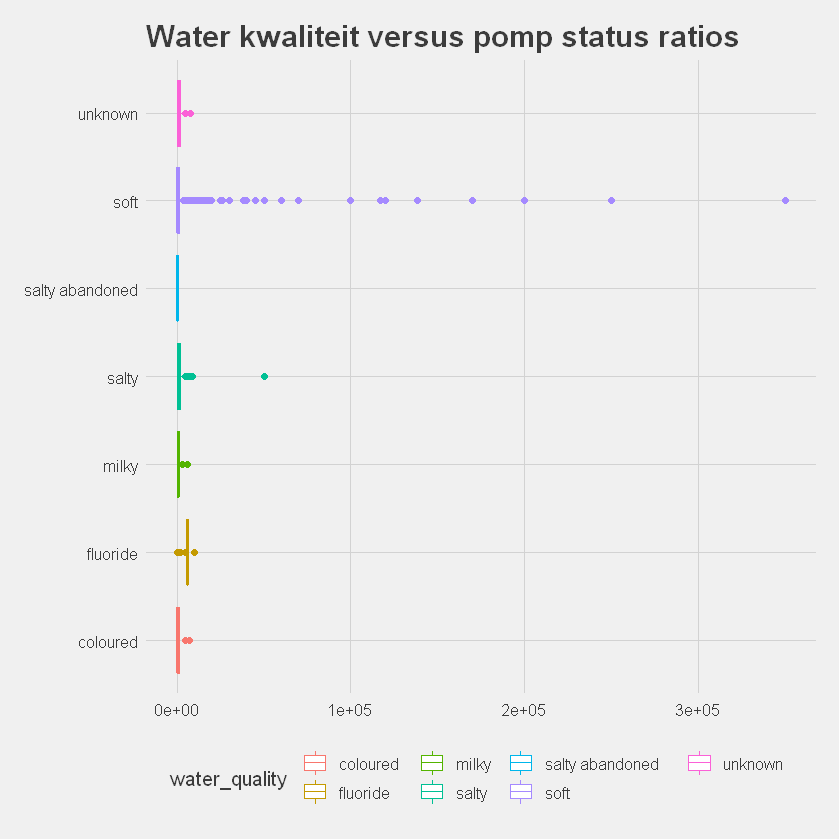

In [287]:
# Is water quality correlated to the water pump status?
df %>% group_by(water_quality, status_group) %>%
    tally() %>%
    group_by(water_quality) %>% mutate(n = n / sum(n)) %>%
    filter(water_quality != "soft") %>%
    ggplot(aes(x = water_quality, y = n, fill = status_group)) +
    geom_bar(stat="identity") + coord_flip() + 
    ggtitle("Water kwaliteit versus pomp status ratios") +
    theme_fivethirtyeight()

# Is water amount available correlated to the water quality?
df %>% group_by(water_quality) %>%
    filter(amount_tsh > 100) %>%
    ggplot(aes(x = water_quality, y = amount_tsh, col = water_quality)) +
    geom_boxplot() + coord_flip() + 
    ggtitle("Water kwaliteit versus pomp status ratios") +
    theme_fivethirtyeight()

The `water_quality` contains more information so we will drop the `quality_group`.

The `water_quality` is also related to the `amount_tsh` in the data, even though we are removing `amount_tsh`(!) The only pumps where a significant amount of water is available is the ones where 'soft' water was found. So even though we are leaving out `amount_tsh`, we will still capture some of its information by including the `water_quality`.

We could improve the visualisation above but it will likely not affect the choices we already made, so let's move on...

#### Quantity and quantity_group

The `quantity` and `quantity_group` sounds like they have the same relation as the water quality. Let's check!


In [288]:
# Cross table of only two variables
df %>% group_by(quantity, quantity_group) %>% tally()



quantity,quantity_group,n
dry,dry,6246
enough,enough,33186
insufficient,insufficient,15129
seasonal,seasonal,4050
unknown,unknown,789


welp.. we checked, and we'll just leave out the `quantity_group` column. 

#### Source, source_class and source_type

In [400]:
# Cross table of only two variables
df %>% group_by(source, source_class, source_type) %>% tally()

source,source_class,source_type,n
dam,surface,dam,656
hand dtw,groundwater,borehole,874
lake,surface,river/lake,765
machine dbh,groundwater,borehole,11075
other,unknown,other,212
rainwater harvesting,surface,rainwater harvesting,2295
river,surface,river/lake,9612
shallow well,groundwater,shallow well,16824
spring,groundwater,spring,17021
unknown,unknown,other,66


The water `source` is more detailed than `source_class` and contains the exact same values as `source_type`. So let's keep only the `source` and `source_type`.
However, the `source_class` contains only 3 categories and this more general distinction may in fact help us make predictions.
We can calculate the feature importance later, so let's keep both variables in our data and verify whether inclusion of `source_class` improves the model at all.

Alternatively, 

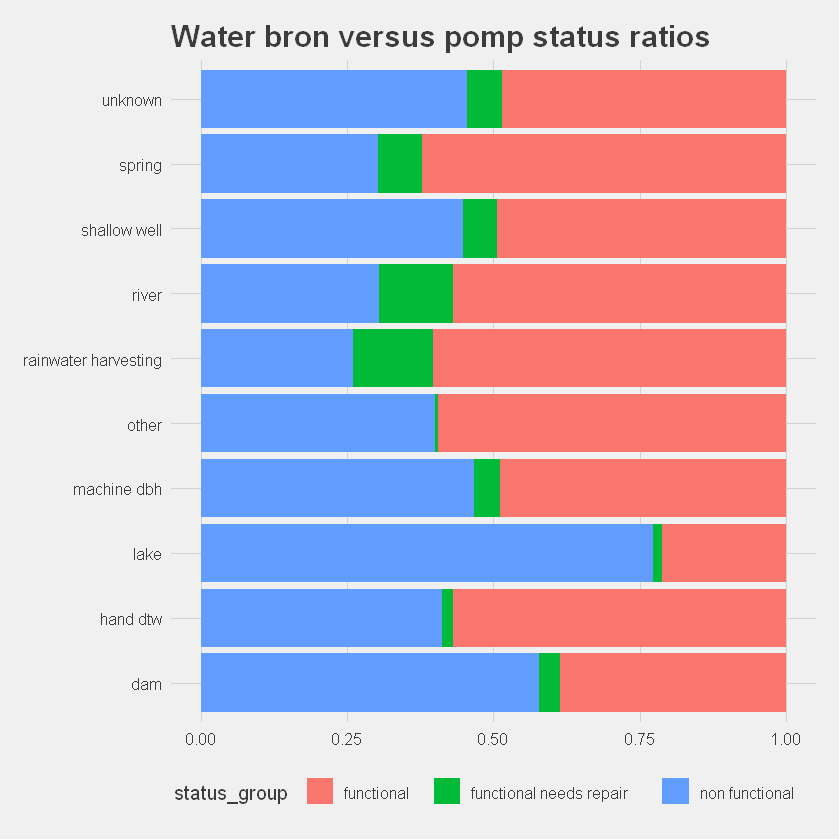

In [401]:
# Is water quality correlated to the water pump status?
df %>% group_by(source, source_class, status_group) %>%
    tally() %>%
    group_by(source) %>% mutate(n = n / sum(n)) %>%
    ggplot(aes(x = source, y = n, fill = status_group)) +
    geom_bar(stat="identity") + coord_flip() + 
    ggtitle("Water bron versus pomp status ratios") +
    theme_fivethirtyeight()

The source is definitely not a perfect prediction of water pump status, but at least a distinction between classes could be beneficial. It remains to be seen whether the water source is truly indicative of the water pump status, why would a pump near a lake be more likely to be non-functional than that near a spring? Unless the water source has dried up, but this would rather affect multiple pumps in the same area.

If there was more time available we could find if there is just a cluster of water pumps at a single lake that are non-functional because of regional differences, for example. The location of a pump probably determines the water source, and since we will already take the gps-coordinates into account we might not be including any new information with the `source` feature.

#### Waterpoint_type and waterpoint_type_group

Finally, this group of two variables may be reduced to a single variable.

In [291]:
# Cross table of only two variables
df %>% group_by(waterpoint_type, waterpoint_type_group) %>% tally()
# They are the exact same variable. So we remove the waterpoint_type_group from our data, later.

waterpoint_type,waterpoint_type_group,n
cattle trough,cattle trough,116
communal standpipe,communal standpipe,28522
communal standpipe multiple,communal standpipe,6103
dam,dam,7
hand pump,hand pump,17488
improved spring,improved spring,784
other,other,6380


#### Conclusion about dealing with grouped data variables

**Remove 9 features**
  - `scheme_name`, `scheme_management` ,    too many unique
  - `extraction_type_group`,    overlaps with `extraction_type` and `extraction_class`
  - `funder` and `installer`,   many missing values, unique values and data-entry inconsistencies
  - `source_class`, `payment`, `waterpoint_type_group`, `management_group` because they are duplicates of other variables
    
**Edit 1 feature**
  - `extraction_type`,  rename some similar categories with very low occurences

Let's make a note of these findings. We will cleanly integrate these steps into our data preprocessing pipeline.
  

In [322]:
df_combined_groups <- df %>% 
    select(-c(scheme_name, scheme_management, extraction_type_group, funder,
              installer, source_class, payment, waterpoint_type_group, management_group)) %>%
    mutate(
        extraction_type = as.character(extraction_type),
        extraction_type = ifelse(extraction_type %in% c("india mark ii", "india mark iii"), "india mark", extraction_type),
        extraction_type = ifelse(extraction_type %in% c("cemo", "climax"), "motorpump", extraction_type),
        extraction_type = ifelse(extraction_type %in% c("other - swn 81", "swn 80"), "swn", extraction_type),
        extraction_type = ifelse(extraction_type %in% c('other - mkulima/shinyanga','other - play pump', 'walimi'), "handpump", extraction_type)
           )
dim(df_combined_groups)
# Write df_combined_groups to csv
#    NOTE THIS IS ACTUALLY HAPPENING IN DEDICATED SCRIPTS, NOT FROM THIS NOTEBOOK
#df %>% write_csv("../../data/interim/data_grouped_vars.csv")

# This part was rewritten into vantage-project/vantage/data/clean_data.py
# The exploration is done in R but final code execution in Python

[1] 59400    32

# Missing values

Now that we have removed some categorical values that we have checked because they seemed grouped with other variables, we still have to take a look at the remaining variables.

While there are no true `NA` values in the data, we have already seen cases where missing values are indicated by empty values, zeroes, or labels like 'none'. Let us look at the feature descriptions again, and take note of the number of unique values and maximum occuring value.

In [312]:
feature_desc %>% filter(Feature %in% colnames(df_combined_groups))

Feature,Description,example,unique,type,nonzero,max_single,max_occurence
amount_tsh,Total static head (amount water available to waterpoint),6000,98,numeric,17761,41639,0
date_recorded,The date the row was entered,2011-03-14,356,factor,59400,572,2011-03-15
gps_height,Altitude of the well,1390,2428,integer,38962,20438,0
longitude,GPS coordinate,34.93809275,57516,numeric,57588,1812,0
latitude,GPS coordinate,-9.85632177,57517,numeric,59400,1812,-2e-08
wpt_name,Name of the waterpoint if there is one,none,37400,factor,59400,3563,none
num_private,,0,65,integer,757,58643,0
basin,Geographic water basin,Lake Nyasa,9,factor,59400,10248,Lake Victoria
subvillage,Geographic location,Mnyusi B,19288,factor,59400,508,Madukani
region,Geographic location,Iringa,21,factor,59400,5294,Iringa


## amount_tsh

We'll **remove** this column as it consists mostly of zeroes, and there is no way for us to distinguish whether these are missing values or just dried up water pumps. I expect that not every included water pump was actually measured as detailed as every other pump. By far the most values are zeroes.

In [317]:
table(df_combined_groups$amount_tsh)[1:10]


    0   0.2  0.25     1     2     5     6     7     9    10 
41639     3     1     3    13   376   190    69     1   806 

## wpt_name

The `wpt_name`, or waterpump name, many unique values and the most occuring values is 'none'.
Now, even the pumps with the same exact name don't actually seem to guarantee the same pump.

This is reason enough to **remove** this feature as unique labels like this will only aid to overfit the model.

In [319]:
# Show some values with wpt_name==Zahanati
# Notice that these are not the same waterpoint at all! 
# So wpt_name is not a variable we'll be able to use
df %>% filter(wpt_name == "Zahanati") %>% select(wpt_name, everything())

wpt_name,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
Zahanati,162,0,2011-08-18,Dwe/norad,1507,DWE,31.94256,-8.63830023,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
Zahanati,229,0,2012-10-22,Hesawa,1541,Hesawa,34.69278,-1.66958309,0,...,soft,good,enough,enough,rainwater harvesting,rainwater harvesting,surface,hand pump,hand pump,functional needs repair
Zahanati,353,0,2013-03-04,,1498,,34.72721,-4.56798440,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
Zahanati,477,0,2013-01-22,Tcrs,1439,TCRS,30.59563,-5.80101901,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
Zahanati,545,0,2011-03-27,Lvia,0,LVIA,36.11867,-6.27763332,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
Zahanati,572,0,2013-02-10,Ministry Of Water,1310,Idara ya maji,34.48949,-5.70545429,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
Zahanati,639,0,2013-03-19,Government Of Tanzania,1076,DWE,36.78773,-3.44342994,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
Zahanati,782,0,2011-08-18,Tasaf,1754,DWE,32.08379,-8.48339295,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
Zahanati,935,0,2013-01-21,Fini Water,263,FINI WATER,38.94797,-9.98744298,0,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
Zahanati,1009,0,2013-03-30,Ncaa,1908,NCAA,35.27337,-3.20382267,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## num_private
The `num_private`, which came without a detailed description, has a loooooottt of zero values.
Again, we cannot differentiate between true 0 values and missing values, since 0 does seem like possible value for `num_private`. We remove this column from further analysis.

In [331]:
# Ratio of values in the data
table(df$num_private)[1:5] / nrow(df) * 100


          0           1           2           3           4 
98.72558923  0.12289562  0.03872054  0.04545455  0.03367003 

## construction_year

Missing values of `construction_year` are indicated by zero-values. How to replace these is not necessarily straightforward since we treat this as a continuous variable! Since the difference between 1955 and 2000 is much smaller than 1955 and 0 we should be careful here! If the construction year is predictive of the water pump status then zero-values will likely introduce a bias.

For missing values we should definitely impute some value. Traditionally the most straightforward way is to just impute the mean or median value. We may correct for region or pump type to improve this imputation. A quick glance at factors that may indicate a missing construction_year we don't find any. So let us use a very simple imputation method to save time.

[1] 2000

id,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,num_private,basin,subvillage,...,management,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,status_group
0,0,2012-11-13,0,33.12583,-5.11815407,Mratibu,0,Lake Tanganyika,Majengo,...,vwc,unknown,milky,milky,enough,enough,shallow well,shallow well,hand pump,non functional
1,0,2011-03-05,1978,34.77072,-9.39564152,none,0,Rufiji,Magoda C,...,vwc,never pay,soft,good,enough,enough,shallow well,shallow well,hand pump,functional
2,0,2011-03-27,0,36.11506,-6.27926803,Bombani,0,Wami / Ruvu,Songambele,...,vwc,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,communal standpipe multiple,functional
3,10,2013-06-03,1639,37.14743,-3.18755455,Area 7 Namba 5,0,Pangani,Urereni,...,water board,per bucket,soft,good,enough,enough,spring,spring,communal standpipe,functional
4,0,2011-03-22,0,36.16489,-6.09928949,Ezeleda,0,Wami / Ruvu,Maata A,...,vwc,unknown,soft,good,dry,dry,shallow well,shallow well,hand pump,non functional
5,50,2011-02-26,28,39.28612,-6.97240273,Kwa Namaj,0,Wami / Ruvu,Mwandege,...,private operator,per bucket,soft,good,enough,enough,machine dbh,borehole,communal standpipe multiple,functional
6,0,2012-10-20,0,33.22988,-3.85298271,Mission,0,Internal,Ngaganulwa,...,vwc,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,other,non functional
7,0,2011-03-23,0,36.31362,-6.71925716,Itawi,0,Rufiji,Mwangaza,...,vwc,never pay,milky,milky,insufficient,insufficient,spring,spring,improved spring,functional
8,0,2011-04-07,0,35.93944,-6.01435820,Kwa Chiswagala,0,Wami / Ruvu,Mazengo,...,private operator,per bucket,soft,good,dry,dry,machine dbh,borehole,communal standpipe multiple,non functional
9,0,2011-07-12,0,31.69337,-2.53070326,Shule Ya Msingi Nyamirembe A,0,Lake Victoria,Miembeni,...,vwc,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,communal standpipe multiple,non functional


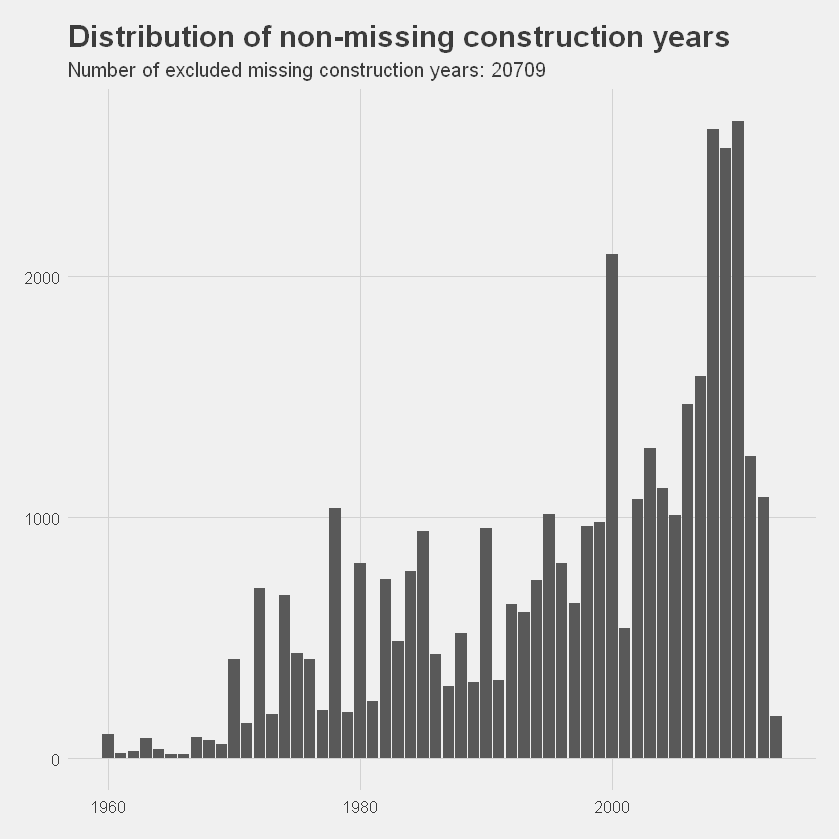

In [399]:
df %>% filter(construction_year > 0) %>%
    ggplot(aes(x = construction_year, color = construction_year)) + geom_bar() + 
    ggtitle("Distribution of non-missing construction years",
           sprintf("Number of excluded missing construction years: %i", sum(df$construction_year == 0))) +
    theme_fivethirtyeight()

median(df$construction_year[df$construction_year > 0])

# Replace construction_year with median of non-zero construction years
df_combined_groups %>%
    mutate(construction_year = replace(construction_year, 
                                       construction_year==0,
                                       median(construction_year[construction_year>0])))

### GPS coordinates

There are three types of gps coordinates in the data,

  - gps_height
  - longitude
  - latitude

We expect these to be continuous values.



In [398]:
# See which gps coordinates occur more than once to reveal missing values
# Maybe some duplicate gps coordinates?? Guess not..
df %>% group_by(gps_height, longitude, latitude) %>%
  tally() %>% filter(n > 2)

gps_height,longitude,latitude,n
0,0,-2e-08,1812




Of all the observations we only find that 1812 observations are missing values, where
gps_height, longitude and latitude are all 0.

We could try to deal with these values in a number of ways,

  - Impute values based on other location data (region_code, district, etc.)
  - Ignore missing values as it only comprises small part of the data
  - At least center the water pumps to somewhere in Tanzania
  
Of course this has varying levels of complexity and for now we simply ignore  missing values
and leave them as is(!) These are fairly hard to deal with and they will probably not have any more value than the other location data such as `region`, `basin` and `district`.

**We leave these as-is.**

